In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.util import LCMEvalUtil
from endure.lcm.model.builder import LearnedCostModelBuilder
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost

In [4]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [31]:
model_path = '/data/models/lcm/qcost_v1/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [32]:
config['job']['LCMTrain']

{'max_epochs': 100,
 'save_dir': 'models/lcm/classic_v1',
 'use_gpu_if_avail': True,
 'loss_fn': 'Huber',
 'optimizer': 'Adam',
 'lr_scheduler': 'CosineAnnealing',
 'no_checkpoint': False,
 'train': {'dir': 'train-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 4096,
  'shuffle': True,
  'num_workers': 12,
  'drop_last': True},
 'test': {'dir': 'test-data/qcost-t30',
  'format': 'parquet',
  'batch_size': 65536,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [33]:
lsm_design

'QLSM'

In [34]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design in ['QLSM', 'QLSMIntegerVars']:
    gen = Gen.QCostGenerator(config)
else:
    gen = Gen.ClassicGenerator(config)

# Loss Graph

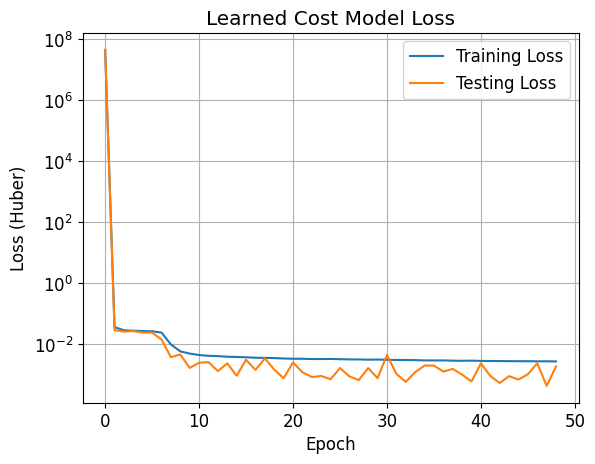

In [35]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[:48]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
ax.set_title(f'Learned Cost Model Loss')
_ = ax.legend()
# save_fig(fig, 'learned_cost_model_loss.pdf')

In [36]:
losses.idxmin()

epoch          0
train_loss    48
test_loss     47
dtype: int64

# Building

## Model

In [37]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_02.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [38]:
torchinfo.summary(model, (1, 70), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
QModel                                   [1, 4]                    --
├─Linear: 1-1                            [1, 8]                    248
├─Linear: 1-2                            [1, 8]                    248
├─BatchNorm1d: 1-3                       [1, 26]                   52
├─Linear: 1-4                            [1, 64]                   1,728
├─ReLU: 1-5                              [1, 64]                   --
├─Dropout: 1-6                           [1, 64]                   --
├─Sequential: 1-7                        [1, 64]                   --
│    └─Linear: 2-1                       [1, 64]                   4,160
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 64]                   4,160
│    └─ReLU: 2-4                         [1, 64]                   --
│    └─Linear: 2-5                       [1, 64]                   4,160
│

# Utils

In [39]:
eval_util = LCMEvalUtil(config, model, gen)

In [40]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=9.428, T=30, policy=<Policy.QFixed: 3>, Q=2, Y=1.0, Z=1.0, K=[])
System(E=2048, s=3.4613468271174525e-08, B=16.0, N=409531932, H=19.142435570047382, phi=1.0)


(1.109678730197921, 1.1046948432922363)

In [41]:
eval_util.gen_random_sample()

({'z0': 0.223,
  'z1': 0.05500000000000002,
  'q': 0.601,
  'w': 0.121,
  'B': 4.0,
  's': 6.779943013179467e-08,
  'E': 8192,
  'H': 13.667007952078215,
  'N': 769373415,
  'h': 6.594,
  'T': 19,
  'Q': 5,
  'cost_lcm': 15.292431831359863,
  'cost_acm': 15.490763251166532},
 LSMDesign(h=6.594, T=19, policy=<Policy.QFixed: 3>, Q=5, Y=1.0, Z=1.0, K=[]),
 System(E=8192, s=6.779943013179467e-08, B=4.0, N=769373415, H=13.667007952078215, phi=1.0))

## LCM Evaluation

In [42]:
num_samples = 10000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row, design, system = eval_util.gen_random_sample()
    norm_delta = (row['cost_acm'] - row['cost_lcm']) / row['cost_acm']
    if (norm_delta < -1) or (norm_delta > 1):
        print(norm_delta, system, design, row['z0'], row['z1'], row['q'], row['w'])
        bad.append((norm_delta, row['z0'], row['z1'], row['q'], row['w'], design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table

  0%|          | 0/10000 [00:00<?, ?it/s]

In [43]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
6117,0.087,0.137,0.005,0.771,64.0,3.268648e-08,1024,13.379988,403620630,3.922,17,7,0.411073,0.458843,0.047770,0.104110
8311,0.907,0.015,0.006,0.072,64.0,4.628889e-08,2048,5.817189,271332112,0.519,9,1,1.012260,1.106707,0.094447,0.085340
6736,0.367,0.023,0.015,0.595,32.0,4.056676e-09,1024,15.150724,614015864,10.118,9,5,0.315958,0.344390,0.028433,0.082559
4398,0.021,0.163,0.795,0.021,32.0,6.714970e-08,1024,19.976223,373865771,19.871,6,4,15.776483,17.092672,1.316190,0.077003
602,0.090,0.348,0.019,0.543,64.0,4.456806e-08,2048,5.469948,399000322,1.187,24,1,0.798228,0.855529,0.057301,0.066977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,0.847,0.017,0.014,0.122,64.0,6.709414e-08,1024,14.402827,202463984,13.428,17,1,0.161060,0.135635,-0.025425,-0.187455
3893,0.465,0.039,0.000,0.496,32.0,1.896221e-08,1024,19.209797,972246070,7.842,10,8,0.273509,0.230234,-0.043274,-0.187958
838,0.537,0.217,0.000,0.246,16.0,8.293741e-08,2048,15.451133,479995986,9.021,21,16,0.531025,0.446147,-0.084879,-0.190248
3671,0.093,0.053,0.002,0.852,32.0,9.141207e-08,2048,17.926791,829157596,6.237,12,10,0.353651,0.295779,-0.057872,-0.195660


In [44]:
# cost, z0, z1, q, w, design, system = bad[0]
# cost, z0, z1, q, w, design, system

In [45]:
acm = eval_util.cf.calc_cost(design, system, z0, z1, q, w)
lcm = eval_util.eval_lcm(design, system, z0, z1, q, w)
acm, lcm, (acm - lcm) / acm

(10.906841620154543, 10.914838790893555, -0.0007332251643073309)

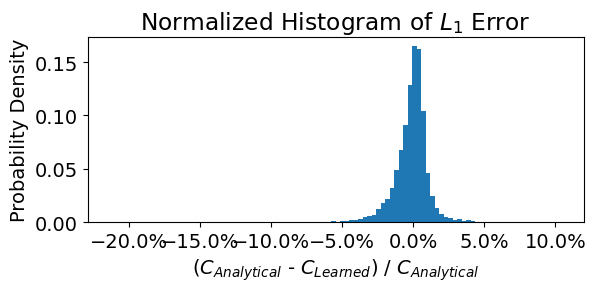

In [46]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6.4, 2.4))
data = df['norm_delta'].values
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_ylabel('Probability Density')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
save_fig(fig, 'learned_cost_model_l1_error.pdf')

In [47]:
cutoff = 0.05
data = df[(df.norm_delta < cutoff) & (df.norm_delta > -cutoff)]
print(f'Percentange within {cutoff:.0%} delta: {len(data) / len(df):.3%}')

Percentange within 5% delta: 99.000%


In [48]:
data = df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
8415,0.088,0.464,0.009,0.439,8.0,8.394612e-08,4096,16.661013,142488283,10.600,12,6,1.093010,1.041338,-0.051672,-0.049621
9544,0.012,0.338,0.213,0.437,64.0,8.382100e-08,1024,9.822396,114089549,2.017,3,1,1.576272,1.501913,-0.074359,-0.049510
624,0.215,0.412,0.004,0.369,16.0,2.788476e-08,2048,13.691077,362770475,13.109,7,4,0.763891,0.728169,-0.035723,-0.049058
8974,0.597,0.254,0.068,0.081,8.0,9.675422e-08,4096,12.707180,174778572,9.920,28,4,1.250906,1.192578,-0.058327,-0.048909
1829,0.741,0.230,0.004,0.025,64.0,8.632363e-08,2048,9.828932,414160161,6.775,20,4,0.450708,0.429705,-0.021003,-0.048878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.240,0.002,0.021,0.737,32.0,3.898076e-08,2048,11.099284,519813122,9.441,21,8,0.591877,0.621920,0.030043,0.048308
7498,0.229,0.140,0.511,0.120,16.0,4.031509e-08,4096,14.690403,524953122,14.582,26,8,13.454908,14.142852,0.687943,0.048642
966,0.238,0.218,0.279,0.265,128.0,3.208065e-08,1024,10.945424,858060292,10.844,23,11,8.888574,9.345224,0.456650,0.048865
2909,0.307,0.202,0.469,0.022,128.0,3.586412e-08,1024,9.054871,404260271,8.950,13,3,5.056157,5.318202,0.262044,0.049273


In [49]:
data = df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
1055,0.136,0.590,0.004,0.270,8.0,8.803598e-08,4096,14.611570,993539775,13.622,30,29,1.338435,1.103509,-0.234926,-0.212890
3671,0.093,0.053,0.002,0.852,32.0,9.141207e-08,2048,17.926791,829157596,6.237,12,10,0.353651,0.295779,-0.057872,-0.195660
838,0.537,0.217,0.000,0.246,16.0,8.293741e-08,2048,15.451133,479995986,9.021,21,16,0.531025,0.446147,-0.084879,-0.190248
3893,0.465,0.039,0.000,0.496,32.0,1.896221e-08,1024,19.209797,972246070,7.842,10,8,0.273509,0.230234,-0.043274,-0.187958
1905,0.847,0.017,0.014,0.122,64.0,6.709414e-08,1024,14.402827,202463984,13.428,17,1,0.161060,0.135635,-0.025425,-0.187455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,0.090,0.348,0.019,0.543,64.0,4.456806e-08,2048,5.469948,399000322,1.187,24,1,0.798228,0.855529,0.057301,0.066977
4398,0.021,0.163,0.795,0.021,32.0,6.714970e-08,1024,19.976223,373865771,19.871,6,4,15.776483,17.092672,1.316190,0.077003
6736,0.367,0.023,0.015,0.595,32.0,4.056676e-09,1024,15.150724,614015864,10.118,9,5,0.315958,0.344390,0.028433,0.082559
8311,0.907,0.015,0.006,0.072,64.0,4.628889e-08,2048,5.817189,271332112,0.519,9,1,1.012260,1.106707,0.094447,0.085340


In [50]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

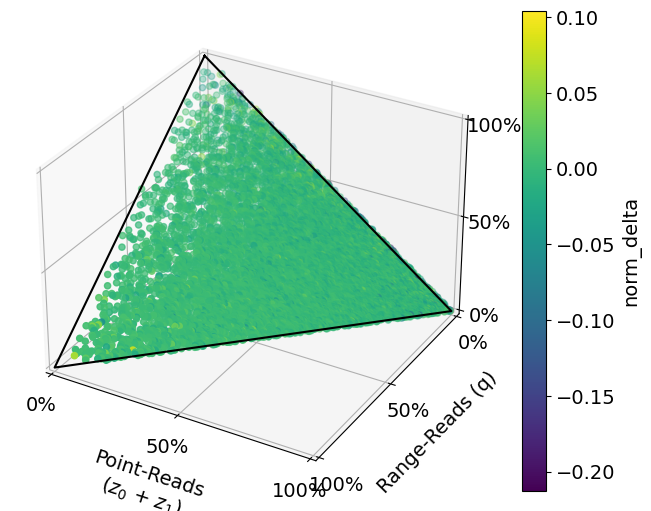

In [51]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')

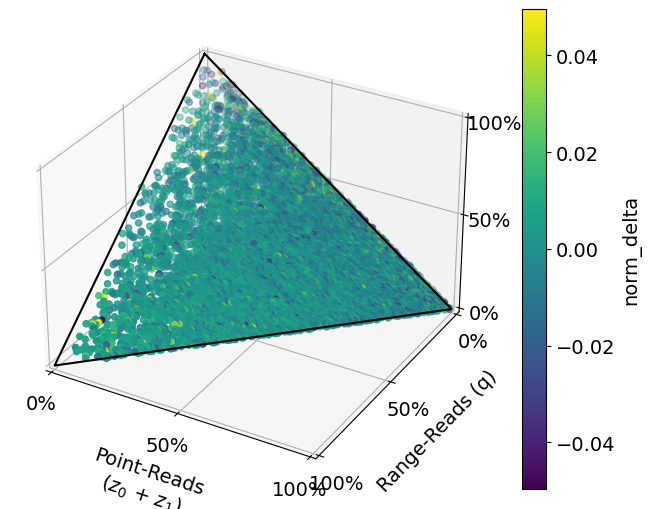

In [52]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)], 'norm_delta')

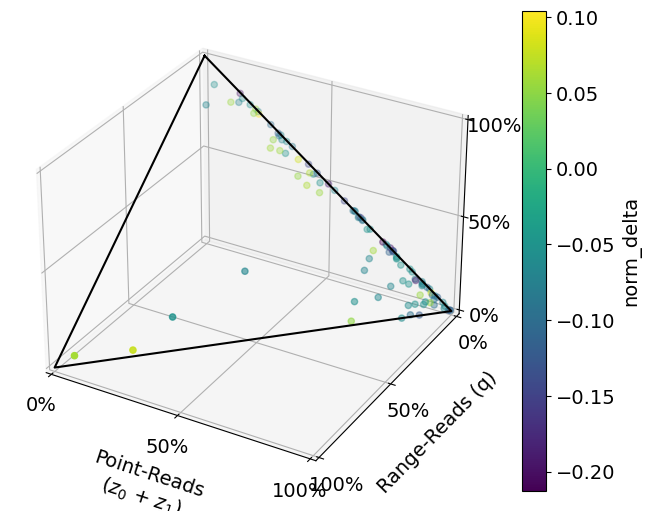

In [53]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)], 'norm_delta')

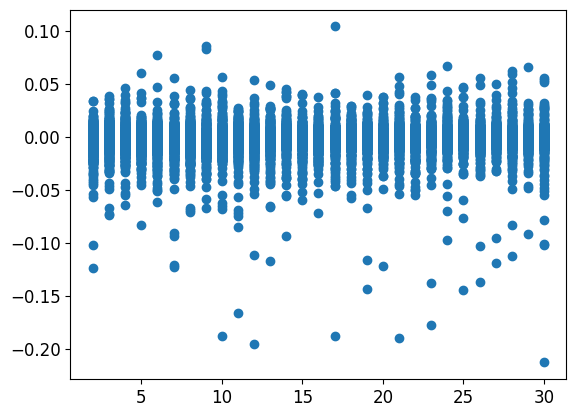

In [54]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.scatter(df['T'], df.norm_delta)
None

In [29]:
acm = eval_util.cf.calc_cost(design, system, z0, z1, q, w)
lcm = eval_util.eval_lcm(design, system, z0, z1, q, w)
acm, lcm, (acm - lcm) / acm

(3.10080080820618, 3.0328571796417236, 0.021911639207731665)

In [30]:
[eval_util.cf.Z0(design, system), eval_util.cf.Z1(design, system), eval_util.cf.W(design, system), eval_util.cf.Q(design, system)] 

[3.1987370814679403, 2.313325932166408, 1.0320852338492503, 16.27995366891692]